In [1]:
%cd ..

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
from collections import OrderedDict
from math import log

import einops
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils import data
from tqdm.auto import tqdm

from made import MADE
from made.layer import MaskedAutoregressiveLinear
from utils.dataset import ObjectCooccurrenceCOCODataset

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.manual_seed(0)

made = MADE(
    MaskedAutoregressiveLinear(80, 256),
    nn.ReLU(),
    MaskedAutoregressiveLinear(256, 256),
    nn.ReLU(),
    MaskedAutoregressiveLinear(256, 80),
)

dataset = dict()
dataset["train"] = ObjectCooccurrenceCOCODataset(
    "dataset/coco2017-cooccurences-train.csv"
)
dataset["test"] = ObjectCooccurrenceCOCODataset(
    "dataset/coco2017-cooccurences-valid.csv"
)

dataloader = dict()
dataloader["train"] = data.DataLoader(dataset["train"], batch_size=128, shuffle=True)
dataloader["test"] = data.DataLoader(dataset["test"], batch_size=128, shuffle=False)

In [4]:
num_sample_train = 1
num_sample_test = 100
patience_max = 30
eps = 1e-5

made = made.to(device)
opt = optim.AdamW(made.parameters(), lr=1e-2)

epochs = 100

record = []
with tqdm(total=epochs, unit="epoch") as pbar:
    patience = 1
    loss_best = torch.inf
    for i in range(epochs):
        pbar.set_description(f"[patience: {patience}/{patience_max}]")

        loss_train = 0
        loss_test = 0

        made.train()
        for inputs in dataloader["train"]:
            inputs = inputs.to(device)
            inputs_ohe = F.one_hot(inputs, 29).float()
            inputs_ohe = einops.rearrange(inputs_ohe, "n d c -> n c d")

            sample = []
            for _ in range(num_sample_train):
                outputs = einops.rearrange(made(inputs_ohe), "n c d -> n d c")
                dist = torch.distributions.Categorical(logits=outputs)
                dist = torch.distributions.Independent(dist, 1)
                sample.append(dist.log_prob(inputs) - log(num_sample_train))
            sample = torch.stack(sample, 1)
            loss = sample.logsumexp(-1).sum().neg()

            (loss / inputs.size(0)).backward()
            opt.step()
            opt.zero_grad()

            loss_train += loss.item()

        made.eval()
        for inputs in dataloader["test"]:
            inputs = inputs.to(device)
            inputs_ohe = F.one_hot(inputs, 29).float()
            inputs_ohe = einops.rearrange(inputs_ohe, "n d c -> n c d")

            sample = []
            with torch.inference_mode():
                for _ in range(num_sample_test):
                    outputs = einops.rearrange(made(inputs_ohe), "n c d -> n d c")
                    dist = torch.distributions.Categorical(logits=outputs)
                    dist = torch.distributions.Independent(dist, 1)
                    sample.append(dist.log_prob(inputs) - log(num_sample_test))
                sample = torch.stack(sample, 1)
                loss = sample.logsumexp(-1).sum().neg()

            loss_test += loss.item()

        loss_train /= len(dataset["train"])
        loss_test /= len(dataset["test"])

        history = OrderedDict(
            loss=loss_train,
            val_loss=loss_test,
        )

        if loss_best > (loss_current := history["val_loss"]):
            patience = 1
            loss_best = loss_current
        else:
            patience = patience + 1

        record.append(history)

        for key, value in history.items():
            history[key] = str(round(value, 4))

        pbar.set_postfix(history)
        pbar.update()

        if patience > patience_max:
            break

  0%|          | 0/100 [00:00<?, ?epoch/s]

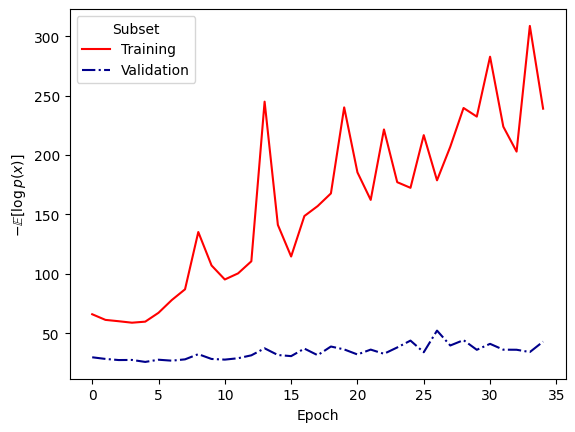

In [5]:
loss = [float(history["loss"]) for history in record]
val_loss = [float(history["val_loss"]) for history in record]

plt.xlabel("Epoch")
plt.ylabel("$-\mathbb{E}[\log p(x)]$")

plt.plot(loss, "-", color="red", label="Training")
plt.plot(val_loss, "-.", color="darkblue", label="Validation")
plt.legend(title="Subset")
plt.show()